<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/3_2_first_classifier_Train_new_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding + first classifier

In [40]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold,train_test_split,cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler


In [41]:
data = pd.read_excel("full_data_with_predictions-VETTING.xlsx")

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [42]:
data

,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך,predicted_probability,prediction_original_model,בקשה לרשות ערעור התקבלה?,טקסט שמצביע על תוצאת בקשה שונה,הערעור התקבל?,"רע""פ בקשה אחרת או דלמטה מיוחד",קידוד,קידוד חוזר,הערות,הערות קידוד חוזר
0,0,2977,"['החלטה בתיק רע""פ 5389/15 בבית המשפט העליון רע...","רע""פ 5389/15","רע""פ 5389/15",2015,"ישראל (24.3.1997); בר""ע 2853/91 פלוני נ\' מדינ...",0.016466,0,נדחה,NaN,NaN,NaN,גל,NaN,NaN,NaN
1,1,2978,"['החלטה בתיק רע""פ 2487/15 בבית המשפט העליון רע...","רע""פ 2487/15","רע""פ 2487/15 אייל אבולפיה נ. עיריית רמת גנ",2015,ופה המוקנית לתובע לצורך מתן מענה לבקשה לביטול ...,0.046868,0,נדחה,NaN,NaN,NaN,דניאל,גל,NaN,NaN
2,2,2979,"['החלטה בתיק רע""פ 4086/15 בבית המשפט העליון רע...","רע""פ 4086/15","רע""פ 4086/15 עבד אגבאריה נ. מדינת ישראל",2015,"וני להכשרת המבנה, הרי שהאינטרס הציבורי של דחיק...",0.029892,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2980,"['פסק דין בתיק רע""פ 8866/15 בבית המשפט העליון ...","רע""פ 8866/15","רע""פ 8866/15 חאזמ רדיע נ. מדינת ישראל",2015,"בין רכיב המאסר לרכיב הפסילה, יש מקום לשוב ולד...",0.958560,1,התקבל,NaN,חלקי,NaN,דניאל,גל,NaN,NaN
4,4,2981,"['החלטה בתיק רע""פ 1094/15 בבית המשפט העליון רע...","רע""פ 1094/15","רע""פ 1094/15 שרית יחיאלוב נ. מדינת ישראל",2015,. עוד אציע לחברותיי כי עונש המאסר בפועל שהושת ...,0.365762,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1473,1473,18335,"['בבית המשפט העליון רע""פ 9288/00 בפני: כבוד הש...","רע""פ 9288/00","רע""פ 9288/00 סמיח עלוש נ. מדינת ישראל",2000,ושהייתה זו בחירתו שלו לטעון לעצמו. אף-על פי-כן...,0.993883,1,התקבל,NaN,התקבל,NaN,גל,דניאל,״ה. הערעור מתקבל במובן זה שהליך הערעור שהוגש ע...,NaN
1474,1474,18340,"[' בבית המשפט העליון רע""פ 4830/00 בפני: כבוד ה...","רע""פ 4830/00","רע""פ 4830/00 יצחק אלקומברה נ. הועדה המקומית לת...",2000,"ב-יפו מיום 5.7.00 בע""פ 70864/00(ב""ש 91552/00) ...",0.503831,1,התקבל,NaN,התקבל,NaN,גל,דניאל,NaN,NaN
1475,1475,18342,"['בבית המשפט העליון בירושלים רע""פ 841/00 בפני:...","רע""פ 841/00","רע""פ 841/00 חברת כורי הצפונ בע""מ נ. מדינת ישראל",2000,"ט המחוזי בחיפה מיום 23.12.99 בע""פ 1008/99 שנית...",0.444206,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1476,1476,18367,"[' בבית המשפט העליון רע""ב 2363/00 בפני: כבוד ה...","רע""פ 2363/00","רע""פ 2363/00 עמרמ כהנ נ. כב' השופט י.כהנ בבית ...",2000,לפטור את המבקש מתשלום אגרהבעתירת אסיר וזאת נוכ...,0.000601,0,נדחה,NaN,NaN,NaN,גל,דניאל,NaN,NaN


In [43]:
data['רע"פ בקשה אחרת או דלמטה מיוחד'].value_counts()
data[(data['רע"פ בקשה אחרת או דלמטה מיוחד'] == 'בקשה אחרת') | (data['רע"פ בקשה אחרת או דלמטה מיוחד'] == 'דלמטה מיוחד')].shape[0]

16

In [44]:
data = data[(data['רע"פ בקשה אחרת או דלמטה מיוחד'] != 'בקשה אחרת') & (data['רע"פ בקשה אחרת או דלמטה מיוחד'] != 'דלמטה מיוחד')]

In [45]:
data = data[(data['בקשה לרשות ערעור התקבלה?'] != 'חלקי') & (data['בקשה לרשות ערעור התקבלה?'] != 'אחר')]

In [46]:
data.dropna(subset=['בקשה לרשות ערעור התקבלה?'],inplace=True)

In [47]:
data['binary_outcome'] = data['בקשה לרשות ערעור התקבלה?'].apply(lambda x: 1 if x == 'התקבל' else 0)

In [48]:
data.shape[0]

239

Confusion Matrix:
[[144  50]
 [  2  43]]


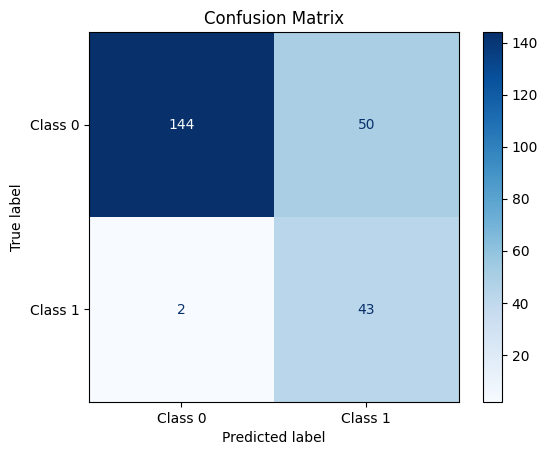

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# יצירת confusion matrix
cm = confusion_matrix(data['binary_outcome'], data['prediction_original_model'])

# הצגת תוצאות confusion matrix
print("Confusion Matrix:")
print(cm)

# ויזואליזציה של confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [50]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import joblib
import pandas as pd

# טעינת המודל והטוקנייזר
tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")

# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]




### Embedding

In [51]:
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_predict, cross_validate
import joblib


# עדכון עמודת המטרה ואימבדינג לאחר חיתוך הטקסטים
y = data["binary_outcome"].values
embeddings = np.array([get_embeddings(text) for text in data["גוף המסמך"]])


### Train and fit

In [52]:
X = embeddings
# טוען את המודל
classifier = joblib.load("classifier_model.pkl")

print("המודל נטען בהצלחה.")

# התאמת המודל לנתונים המאוזנים
classifier.fit(X, y)

# הגדרת מדדים לקרוס ולידציה
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע Cross Validation
cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)

# חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
y_pred = cross_val_predict(classifier, X, y, cv=5)
conf_matrix = confusion_matrix(y, y_pred)

# הדפסת התוצאות
print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")


# --- שמירת משאבים ---
joblib.dump(classifier, 'classifier_model_double_trained.pkl')

print("המודל והמשאבים נשמרו בהצלחה.")


המודל נטען בהצלחה.
Cross-Validation Accuracy: [0.97916667 0.91666667 0.8125     0.875      0.85106383]
Mean Accuracy: 0.8868794326241135
Cross-Validation Precision for Class 1: [1.         0.77777778 0.5        0.8        0.57142857]
Mean Precision for Class 1: 0.7298412698412697
Cross-Validation Recall for Class 1: [0.88888889 0.77777778 0.77777778 0.44444444 0.88888889]
Mean Recall for Class 1: 0.7555555555555554
Cross-Validation F1 Score for Class 1: [0.94117647 0.77777778 0.60869565 0.57142857 0.69565217]
Mean F1 Score for Class 1: 0.7189461291763082
Confusion Matrix with Labels:
True Negatives (TN): 178
False Positives (FP): 16
False Negatives (FN): 11
True Positives (TP): 34

Confusion Matrix:
[[178 16]
 [11 34]]
המודל והמשאבים נשמרו בהצלחה.


In [53]:
# חיזוי הסתברויות לכל קפל לצורך שינוי סף
y_prob = cross_val_predict(classifier, X, y, cv=5, method='predict_proba')[:, 1]

# קביעת סף חדש
threshold = 0.1
y_pred = (y_prob >= threshold).astype(int)

# יצירת קונפיושן מטריקס
conf_matrix = confusion_matrix(y, y_pred)
# חישוב מדדים עם הסף החדש
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, pos_label=1)
recall = recall_score(y, y_pred, pos_label=1)
f1 = f1_score(y, y_pred, pos_label=1)

print("\nמדדים לאחר שינוי סף הסיווג:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision for Class 1: {precision:.3f}")
print(f"Recall for Class 1: {recall:.3f}")
print(f"F1 Score for Class 1: {f1:.3f}")

# # הדפסת התוצאות
# print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
# print("Mean Accuracy:", cv_results['test_accuracy'].mean())
# print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
# print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
# print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
# print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
# print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
# print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")

# --- שמירת משאבים ---
joblib.dump(classifier, 'classifier_model_double_trained.pkl')

print("המודל והמשאבים נשמרו בהצלחה.")


מדדים לאחר שינוי סף הסיווג:
Accuracy: 0.795
Precision for Class 1: 0.477
Recall for Class 1: 0.933
F1 Score for Class 1: 0.632
Confusion Matrix with Labels:
True Negatives (TN): 148
False Positives (FP): 46
False Negatives (FN): 3
True Positives (TP): 42

Confusion Matrix:
[[148 46]
 [3 42]]
המודל והמשאבים נשמרו בהצלחה.


### FN print


In [54]:

# איתור האינדקסים של FN - תווית אמיתית היא 1 והתחזית היא 0
fn_indices = np.where((y == 1) & (y_pred == 0))[0]


# קריאת השורות הרלוונטיות מה-DataFrame
false_negative_rows = data.iloc[fn_indices]

# ווידוא סינכרון מוחלט של האינדקסים
if len(false_negative_rows) != len(fn_indices):
    raise ValueError("Mismatch between FN rows and FN indices!")

# הדפסת פסקי הדין של FN בצורה מפורמטת עם הערכים המקוריים והתחזית להשוואה
print("False Negative Cases (True Label: 1, Predicted Label: 0):")
print("=" * 80)

for i, (index, row) in enumerate(false_negative_rows.iterrows(), 1):
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)

    # הדפסת binary_outcome (תווית אמיתית)
    print("\nBinary Outcome (True Label):")
    print(row["binary_outcome"])

    # הדפסת התחזית (Predicted Label)
    print("\nPredicted Label:")
    print(0)  # FN משמעותו שהתחזית היא 0

    # הדפסת גוף המסמך אם קיים
    if "גוף המסמך" in row:
        print("\nDocument Body:")
        formatted_text = "\n".join(row["גוף המסמך"][j:j + 80] for j in range(0, len(row["גוף המסמך"]), 80))
        print(formatted_text)
    else:
        print("\nDocument Body: Not Available")

    # הדפסת גוף המסמך חתוך אם קיים
    if "גוף המסמך חתוך" in row:
        print("\nDocument Body (Trimmed):")
        formatted_text_trimmed = "\n".join(row["גוף המסמך חתוך"][j:j + 80] for j in range(0, len(row["גוף המסמך חתוך"]), 80))
        print(formatted_text_trimmed)
    else:
        print("\nDocument Body (Trimmed): Not Available")

    # הדפסת שאר העמודות הרלוונטיות
    relevant_columns = [
        "בקשה לרשות ערעור התקבלה?", "טקסט שמצביע על תוצאת בקשה שונה",
        "הערעור התקבל?", "רע\"פ בקשה אחרת או דלמטה מיוחד",
        "קידוד", "קידוד חוזר", "הערות", "הערות קידוד חוזר"
    ]
    print("\nRelevant Columns Data:")
    for col in relevant_columns:
        if col in row:
            print(f"{col}: {row[col]}")
        else:
            print(f"{col}: Not Available")

    print("-" * 80)

print("=" * 80)


False Negative Cases (True Label: 1, Predicted Label: 0):

Case 1:
--------------------------------------------------------------------------------
Index in Original Data:
333

Binary Outcome (True Label):
1

Predicted Label:
0

Document Body:
['פסק-דין בתיק רע"פ 7383/05 בבית המשפט העליון רע"פ 7383/05 בפני: כבוד השופט א\' 
א\' לוי כבוד השופט א\' גרוניס כבוד השופטת מ\' נאור המבקש: נועם נאור נ ג ד המשיבה
: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בתל-אביב-יפו, מיום
 14.7.05, בתיק ע"פ 71717/04, שניתן על ידי כבוד השופטים: ד\' ברלינר, ז\' המר, י\'
 שיצר בשם המבקש: עו"ד יואב ספיר, עו"ד עדי לבוק-שובי בשם המשיבה: עו"ד עו"ד דניאלה
 ביניש פסק-דין השופט א\' א\' לוי: המבקש הואשם בבית-משפט השלום בכפר-סבאבעבירה של 
צעדי פזיזות ורשלנות – אי נקיטת צעדי זהירות בחיה, עבירה לפי סעיף388(6) לחוק העונש
ין, תשל"ז-1977. על-פי הנטען בכתב האישום, המבקש לא נקטאמצעי-זהירות מתאימים ביחס ל
כלבים שבהחזקתו, אשר התנפלו על עובר-אורח ופצעוהו.המבקש כפר בעובדותיו של כתב-האישו
ם, ופנה לבית-המשפט בבקשה למ

In [55]:
# חיזוי תוויות על כל קפל לצורך זיהוי FP
y_pred = cross_val_predict(classifier, X, y, cv=5)

# איתור האינדקסים של FP - תווית אמיתית היא 0 והתחזית היא 1
fp_indices = np.where((y == 0) & (y_pred == 1))[0]


# קריאת השורות הרלוונטיות מה-DataFrame
false_positive_rows = data.iloc[fp_indices]

# ווידוא סינכרון מוחלט של האינדקסים
if len(false_positive_rows) != len(fp_indices):
    raise ValueError("Mismatch between FP rows and FP indices!")

# הדפסת פסקי הדין של FP בצורה מפורמטת עם הערכים המקוריים והתחזית להשוואה
print("False Positive Cases (True Label: 0, Predicted Label: 1):")
print("=" * 80)

for i, (index, row) in enumerate(false_positive_rows.iterrows(), 1):
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)

    # הדפסת binary_outcome (תווית אמיתית)
    print("\nBinary Outcome (True Label):")
    print(row["binary_outcome"])

    # הדפסת התחזית (Predicted Label)
    print("\nPredicted Label:")
    print(1)  # FP משמעותו שהתחזית היא 1

    # הדפסת גוף המסמך אם קיים
    if "גוף המסמך" in row:
        print("\nDocument Body:")
        formatted_text = "\n".join(row["גוף המסמך"][j:j + 80] for j in range(0, len(row["גוף המסמך"]), 80))
        print(formatted_text)
    else:
        print("\nDocument Body: Not Available")

    # הדפסת גוף המסמך חתוך אם קיים
    if "גוף המסמך חתוך" in row:
        print("\nDocument Body (Trimmed):")
        formatted_text_trimmed = "\n".join(row["גוף המסמך חתוך"][j:j + 80] for j in range(0, len(row["גוף המסמך חתוך"]), 80))
        print(formatted_text_trimmed)
    else:
        print("\nDocument Body (Trimmed): Not Available")

    # הדפסת שאר העמודות הרלוונטיות
    relevant_columns = [
        "בקשה לרשות ערעור התקבלה?", "טקסט שמצביע על תוצאת בקשה שונה",
        "הערעור התקבל?", "רע\"פ בקשה אחרת או דלמטה מיוחד",
        "קידוד", "קידוד חוזר", "הערות", "הערות קידוד חוזר"
    ]
    print("\nRelevant Columns Data:")
    for col in relevant_columns:
        if col in row:
            print(f"{col}: {row[col]}")
        else:
            print(f"{col}: Not Available")

    print("-" * 80)

print("=" * 80)


False Positive Cases (True Label: 0, Predicted Label: 1):

Case 1:
--------------------------------------------------------------------------------
Index in Original Data:
294

Binary Outcome (True Label):
0

Predicted Label:
1

Document Body:
['החלטה בתיק רע"פ 5951/15 בבית המשפט העליון רע"פ 5951/15 לפני: כבוד השופט ס\' ג\
'ובראן כבוד השופט א\' שהם כבוד השופטת ד\' ברק-ארז המבקש: פארס חזימיה נגד המשיבה:
 מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בחיפה מיום 17.6.201
5 בעפ"ג 12284-04-15 שניתן על ידי כבוד השופטים: ר\' שפירא – סג"נ, א\' אליקים וב\'
 טאובר תאריך הישיבה: י"ד בסיון התשע"ו (20.6.2016) בשם המבקש: עו"ד אלון נשר; עו"ד
 נאג\'י עאמר בשם המשיבה: עו"ד הילה גורני פסק דין בהמלצתנו חזר בו המבקש מבקשתו, ו
הבקשה למתן רשות ערעור נדחית בזה. ניתן היום, י"ד בסיון התשע"ו (20.6.2016). ש ו פ 
ט ש ו פ ט ש ו פ ט ת _________________________ העותק כפוף לשינויי עריכה וניסוח. 1
5059510_H06.doc שצ מרכז מידע, טל\' 077-2703333 ; אתר אינטרנט, www.court.gov.il']

Document Body (Trimmed):
ל

Undersampling

In [56]:

# הגדרת undersampler עם יחס של60-40 לטובת קלאס 0
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(embeddings, y)

# שמירת אינדקסים מקוריים
resampled_indices = undersampler.sample_indices_
joblib.dump(resampled_indices, 'resampled_indices.pkl')

# ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values
if not np.array_equal(y_resampled, binary_outcome_resampled):
    raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

# הגדרת מסווג לוגיסטי עם משקל של 3 עבור קלאס 1
classifier = joblib.load("classifier_model.pkl")

# התאמת המודל לנתונים המאוזנים
classifier.fit(X_resampled, y_resampled)

# הגדרת מדדים לקרוס ולידציה
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע Cross Validation
cv_results = cross_validate(classifier, X_resampled, y_resampled, cv=5, scoring=scoring)

# חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)
conf_matrix = confusion_matrix(y_resampled, y_pred)

# הדפסת התוצאות
print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")

# --- לוגיקה למציאת threshold אופטימלי ---
predicted_probabilities = classifier.predict_proba(X_resampled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_resampled, predicted_probabilities)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Threshold אופטימלי לפי F1 Score: {optimal_threshold}")

# שמירת יחס הכיתות המקורי
class_ratio_original = sum(y == 1) / len(y)
print(f"יחס כיתות מקורי (Class 1): {class_ratio_original:.2f}")

# --- שמירת משאבים ---
joblib.dump(classifier, 'classifier_model_second_undersampled.pkl')
joblib.dump(optimal_threshold, 'optimal_threshold.pkl')
joblib.dump(class_ratio_original, 'class_ratio_original.pkl')

print("המודל והמשאבים נשמרו בהצלחה.")


Cross-Validation Accuracy: [0.91666667 0.875      0.875      0.91666667 0.875     ]
Mean Accuracy: 0.8916666666666666
Cross-Validation Precision for Class 1: [0.88888889 0.875      0.875      0.88888889 0.75      ]
Mean Precision for Class 1: 0.8555555555555555
Cross-Validation Recall for Class 1: [0.88888889 0.77777778 0.77777778 0.88888889 1.        ]
Mean Recall for Class 1: 0.8666666666666666
Cross-Validation F1 Score for Class 1: [0.88888889 0.82352941 0.82352941 0.88888889 0.85714286]
Mean F1 Score for Class 1: 0.8563958916900093
Confusion Matrix with Labels:
True Negatives (TN): 68
False Positives (FP): 7
False Negatives (FN): 6
True Positives (TP): 39

Confusion Matrix:
[[68 7]
 [6 39]]
Threshold אופטימלי לפי F1 Score: 0.7993781673545164
יחס כיתות מקורי (Class 1): 0.19
המודל והמשאבים נשמרו בהצלחה.


In [57]:
# חיזוי הסתברויות לכל קפל לצורך שינוי סף
y_prob = cross_val_predict(classifier, X, y, cv=5, method='predict_proba')[:, 1]

# קביעת סף חדש
threshold = 0.1
y_pred = (y_prob >= threshold).astype(int)

# יצירת קונפיושן מטריקס
conf_matrix = confusion_matrix(y, y_pred)
# חישוב מדדים עם הסף החדש
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, pos_label=1)
recall = recall_score(y, y_pred, pos_label=1)
f1 = f1_score(y, y_pred, pos_label=1)

print("\nמדדים לאחר שינוי סף הסיווג:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision for Class 1: {precision:.3f}")
print(f"Recall for Class 1: {recall:.3f}")
print(f"F1 Score for Class 1: {f1:.3f}")

# # הדפסת התוצאות
# print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
# print("Mean Accuracy:", cv_results['test_accuracy'].mean())
# print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
# print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
# print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
# print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
# print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
# print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")

# --- שמירת משאבים ---
joblib.dump(classifier, 'classifier_model_second_undersampled.pkl')

print("המודל והמשאבים נשמרו בהצלחה.")


מדדים לאחר שינוי סף הסיווג:
Accuracy: 0.795
Precision for Class 1: 0.477
Recall for Class 1: 0.933
F1 Score for Class 1: 0.632
Confusion Matrix with Labels:
True Negatives (TN): 148
False Positives (FP): 46
False Negatives (FN): 3
True Positives (TP): 42

Confusion Matrix:
[[148 46]
 [3 42]]
המודל והמשאבים נשמרו בהצלחה.
